#### FAKE NEWS DETECTION MODEL

###### --------------------

##### LIBRARIES

In [8]:
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import json

import spacy
nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords

import sklearn
from sklearn.calibration import calibration_curve
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

import warnings
pd.set_option('display.max_rows', None)


In [9]:
sklearn.__version__

'1.1.1'

##### READ DATA

In [2]:
current_wd = os.getcwd()
print("-- CURRENT DIRECTORY: %s" %current_wd)

-- CURRENT DIRECTORY: /Users/mhsaleem/Documents/Personal/MML_Assignment


In [ ]:
file_path_train = current_wd+'/fake_news/train.csv'
file_path_test = current_wd+'/fake_news/test.csv'
file_path_labels = current_wd+'/fake_news/labels.csv'

def create_df(train_path, test_path, label_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(file_path_test)
    test_labels = pd.read_csv(file_path_labels)

    test_final = pd.merge(test_data, test_labels, how = "inner", left_on='id',right_on='id')

    train_data["wc_heading"] = train_data["title"].apply(lambda n: len(str(n).split()))
    train_data["wc_news"] = train_data["text"].apply(lambda n: len(str(n).split()))
    test_final["wc_heading"] = test_final["title"].apply(lambda n: len(str(n).split()))
    test_final["wc_news"] = test_final["text"].apply(lambda n: len(str(n).split()))

    return train_data, test_final

In [ ]:
df_train, df_test = create_df(file_path_train, file_path_test, file_path_labels)
print("df_train shape {}".format(df_train.shape))
print("df_test shape {}".format(df_test.shape))
print("-------")
print("TRAIN COUNT")
print(df_train.groupby('label').id.count())
print("TEST COUNT")
print(df_test.groupby('label').id.count())

df_train.head(5)

In [ ]:
df_test.head(10)

In [3]:
df_train = pd.read_csv(current_wd+'/df_train_clean_lstm.csv')
df_test = pd.read_csv(current_wd+'/df_test_clean_lstm.csv')

df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['Unnamed: 0'])

print("df_train shape {}".format(df_train.shape))
print("df_test shape {}".format(df_test.shape))
print("-------")
print("TRAIN COUNT")
print(df_train.groupby('label').id.count())
print("TEST COUNT")
print(df_test.groupby('label').id.count())

df_train.head(5)

df_train shape (20225, 16)
df_test shape (5058, 16)
-------
TRAIN COUNT
label
0    10385
1     9840
Name: id, dtype: int64
TEST COUNT
label
0    2336
1    2722
Name: id, dtype: int64


,id,title,author,text,label,clean_title,clean_text,clean_author,wc_heading,wc_news,wc_heading_clean,wc_news_clean,ratio_news_clean_orig,ratio_head_clean_orig,combined_clean,lstm_prob
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide do not even see comey letter ja...,house dem aide do not even see comey letter ja...,darrell lucus,14,820,12,461,0.562195,0.857143,darrell lucus house dem aide do not even see c...,0.993984
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,daniel j flynn,9,710,7,378,0.532394,0.777778,daniel j flynn ever get feeling life circle ro...,0.373942
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fire,truth might get fire october 29 2016 tension i...,consortiumnewscom,7,1266,4,704,0.556082,0.571429,consortiumnewscom truth might get fire october...,0.988899
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilian kill single us airstrike identify,video 15 civilian kill single us airstrike ide...,jessica purkiss,10,557,7,306,0.549372,0.700000,jessica purkiss video 15 civilian kill single ...,0.385617
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jail fictional unpublished story...,print iranian woman sentence year prison iran ...,howard portnoy,14,154,10,87,0.564935,0.714286,howard portnoy print iranian woman sentence ye...,0.977961


In [4]:
#df_train[['clean_title', 'clean_author']] = df_train[['clean_title', 'clean_author']].fillna(value = 'missing')
#df_test[['clean_title', 'clean_author']] = df_test[['clean_title', 'clean_author']].fillna(value = 'missing')
df_train.isna().sum()

id                       0
title                    0
author                   0
text                     0
label                    0
clean_title              0
clean_text               0
clean_author             0
wc_heading               0
wc_news                  0
wc_heading_clean         0
wc_news_clean            0
ratio_news_clean_orig    0
ratio_head_clean_orig    0
combined_clean           0
lstm_prob                0
dtype: int64

In [ ]:
df_test.dtypes

In [ ]:
len(df_train[df_train.wc_news < 20])

In [ ]:
## heading count is 40
df_train[['wc_heading','wc_news']].describe()

In [ ]:
df_test[['wc_heading','wc_news']].describe()

In [ ]:
texts = [
    "House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It",
    "Revenue exceeded twelve billion dollars!!!!, with a loss of $1b.",
]

docs = list(nlp.pipe(texts))

In [ ]:
docs

In [ ]:
print(nlp.pipe_names)

In [ ]:
b=[]
for token in docs[0]:
    print(token.text, token.lemma_, token.pos_, token.is_digit, token.is_alpha, token.is_stop)

    if token.is_alpha or token.pos_ == 'NUM':
        b.append(token.lemma_)

' '.join(b)


In [ ]:
nlp.Defaults.stop_words -= {"nothing", "empty", "everything","did","except","should","do","not"}
print(nlp.Defaults.stop_words)

In [ ]:
a="what's the name aren't didn’t"
each_text = re.sub(r"\'s", " is", a)
each_text = re.sub(r"n\'t", " not", each_text)
each_text = re.sub(r"n\’t", " not", each_text)

each_text

##### PREPROCESSING

In [ ]:

f = open(current_wd+'/output/word_count.json')
word_count_dict = json.load(f)
f.close()

word_count_dict['house']

In [ ]:
# %%
####################################################################################
# stop words
####################################################################################
nltk.download('stopwords')
#nltk.download('punkt')
stop_words_nltk = nltk.corpus.stopwords.words('english')
stop_words_nltk = stop_words_nltk + ['','ag_text','cx_text','agtext','cxtext','hi','hello','amazon','please',
                        'itis','thatis','mm','eh','ummm','wo','st','would','name','oh','amazonis',
                        'one','two','five','hermes','emailaddress','chat','nine','orderid','seven',
                        'eight','twenty','six','yet','thereis','ahhh','pounds','dot','url','id','ml','um',
                        'four','bz','thousand','I','mr','•','phonenumber','rd']

sto_word_list_remove = ['no', 'nor', 'not', 'only','again','against','do', 'should', 'are']

for word in sto_word_list_remove: 
    stop_words_nltk.remove(word)
    
print(stop_words_nltk)

In [ ]:
import time

# %%
####################################################################################
# CLEAN
####################################################################################
def clean_text(each_text):

    each_text = str(each_text).lower()
    each_text = re.sub(r"what's", "what is ", each_text)
    each_text = re.sub(r"sheis", "she is ", each_text)
    
    each_text = re.sub(r"http\S+", "", each_text)
    each_text = re.sub(r"cannot", "can not", each_text) ##--different
    each_text = re.sub(r"whatis", "what is", each_text) ##--different
    each_text = re.sub(r"\'s", " is", each_text)
    #each_text = each_text.replace(r".", "", each_text)
    each_text = re.sub(r"\’s", " is", each_text)
    each_text = re.sub(r"\'ve", " have", each_text)
    each_text = re.sub(r"n\’t", " not", each_text)
    each_text = re.sub(r"n\'t", " not", each_text)
    each_text = re.sub(r"i\'m", "i am", each_text)
    each_text = re.sub(r"i\’m", "i am", each_text)
    each_text = re.sub(r"\'ve", " have", each_text)
    each_text = re.sub(r"\'re", " are ", each_text)
    each_text = re.sub(r"\’re", " are ", each_text)
    each_text = re.sub(r"\'d", " would ", each_text)
    each_text = re.sub(r"\'ll", " will ", each_text)
    each_text = re.sub(r"\’ll", " will ", each_text)
    each_text = re.sub(r"\\", "", each_text)
    each_text = re.sub(r"\'", "", each_text)
    each_text = re.sub(r"\"", "", each_text)
    each_text = re.sub(r" ;",";", each_text)
    #each_text = re.sub('[^a-zA-Z; ?!]+', '', each_text)
    #each_text = re.sub(r'\d+', '', each_text)
    each_text = re.sub(r'&amp;?', r'and', each_text)  # replace & -> and
    each_text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", each_text)  # Remove URLs
    each_text = re.sub('[^A-Za-z0-9; ]+', '', each_text) ##keep only words and digits
    each_text = re.sub('\s+', ' ', each_text).strip()  # Remove and double spaces

    each_text = each_text.strip()
    
        
    return " ".join(each_text.split())

def clean_text_dataframe(df, col_to_use):
    df[col_to_use+'_step_clean'] = df[col_to_use].apply(lambda x: clean_text(x))
    list_of_all_text = df[col_to_use+'_step_clean'].values.tolist()
    #print("type of list: %s" %type(list_of_all_text))
    #print(list_of_all_text)

    docs = list(nlp.pipe(list_of_all_text))
    docs_clean = []
    for single_doc in docs:
        #print(single_doc)
        single_doc_tokens = []
        for token in single_doc:
            #print(token.text, token.lemma_, token.pos_, token.is_digit, token.is_alpha)
            if (token.is_alpha or token.pos_ == 'NUM') and (token.lemma_ not in stop_words_nltk):
                #print("in here")
                #print(word_count_dict[token.lemma_])
                #if token.lemma_ in word_count_dict:
                 #   print(word_count_dict[token.lemma_])
                    #if word_count_dict[token.lemma_] > 1:
                single_doc_tokens.append(token.lemma_)
                #else:
                 #  single_doc_tokens.append(token.lemma_)

        docs_clean.append(" ".join(single_doc_tokens))
    
    return docs_clean

def start_df_cleaning(df):
    # dropping missing values from text columns alone. 
    df[['title', 'author']] = df[['title', 'author']].fillna(value = 'missing')
    df = df.dropna()
    #df = df[df.wc_news > 20]
    
    print("Shape of df {}".format(df.shape))
    print(sum(df.isnull().sum()))

    df['clean_title'] = clean_text_dataframe(df, 'title')
    df['clean_text'] = clean_text_dataframe(df, 'text')
    df['clean_author'] = clean_text_dataframe(df, 'author')

    df["wc_heading_clean"] = df["clean_title"].apply(lambda n: len(str(n).split()))
    df["wc_news_clean"] = df["clean_text"].apply(lambda n: len(str(n).split()))

    cols_to_use = ['id','title','author','text','label','clean_title','clean_text','clean_author','wc_heading','wc_news','wc_heading_clean','wc_news_clean']
    df = df[cols_to_use]
    df['ratio_news_clean_orig'] = df.wc_news_clean / df.wc_news
    df['ratio_head_clean_orig'] = df.wc_heading_clean / df.wc_heading
    df = df[df.wc_news_clean > 10]

    return df


In [ ]:
df_train_rand = start_df_cleaning(df_train.head(4))
df_train_rand

In [ ]:
#df_test_sample = df_train.head(3).copy()
# get the start time
st = time.time()

df_train = start_df_cleaning(df_train)
print("DONE WITH TRAIN")
df_test = start_df_cleaning(df_test)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

In [ ]:
df_train.head(3)

In [ ]:
word_count_dict['aide']

In [ ]:
df_train.to_csv(current_wd+'/data_train_clean.csv')
df_test.to_csv(current_wd+'/data_test_clean.csv')
print("DONE WRITING")

In [ ]:
print(df_train.shape)
print(df_test.shape)

In [ ]:
print(len(df_train[df_train.wc_news_clean < 1500])) ##covers 98%
df_train[['wc_news_clean','wc_heading_clean']].describe()

In [ ]:
##WORD COUNT
v = df_train['clean_text'].str.split().tolist()
c = Counter(chain.from_iterable(v))

##### BASIC CURVE PLOTTING

In [5]:
def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

#%%
# =============================================================================
# FUnction for probability calibration (get probability threshold for a precision)
# Returns - 
#    Probability threshold 
#    actual & predicted based on threshold 
#    confusion matrix
# =============================================================================
def validation_probability_threshold(actual,predicted_prob,label):

    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn import metrics
    import numpy as np

    print('{} AUC is: {}'.format(label, metrics.roc_auc_score(actual,predicted_prob)))
    fpr, tpr, _ = metrics.roc_curve(actual, predicted_prob)
    auc = metrics.roc_auc_score(actual, predicted_prob)

    precision, recall, threshold = metrics.precision_recall_curve(actual, predicted_prob, pos_label=None,sample_weight=None)
    #    
    d = {'precision': precision[:-1], 'recall': recall[:-1],'threshold':threshold}
    prt = pd.DataFrame(data=d)
    prt['f1Score'] = 2*prt['precision']*prt['recall']/(prt['precision']+prt['recall'])
    prt['precision_floor'] = np.floor(prt['precision']*100)/100
    
    print("shape of prt {}".format(prt.shape))
    #print(prt)

    final_threshold = 0.5
    final_threshold_loc = prt.loc[prt['precision']==prt['recall'],'threshold'] #.values[0]
    if len(final_threshold_loc) > 0:
        final_threshold = final_threshold_loc.values[0]
    else:
        print("*** CANT FIND PREC = RECALL - forcing to %s" %final_threshold)
    print('Probability threshold:'+str(final_threshold))

    fn = pd.concat([pd.DataFrame(actual).reset_index(drop=True),pd.DataFrame(predicted_prob)],axis=1)
    fn.columns = ('actual','predicted_prob')
    #    fn = pd.concat([pd.DataFrame(actual),pd.DataFrame(predicted_prob)],axis=1)
    #    fn.columns = ('actual','predicted_prob')
#    fn.loc[(fn['predicted_prob']>=float(final_threshold)),'predicted'] = 1
#    fn.loc[(fn['predicted_prob']<float(final_threshold)),'predicted'] = 0
    fn['predicted'] = np.where(fn['predicted_prob']>=float(final_threshold),1,0)
#    fn['predicted'] = fn['predicted'].astype(int)
    cnf_mat = metrics.confusion_matrix(fn['actual'], fn['predicted'])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr,label="AUC="+str(auc))
    plt.plot(fpr, fpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve for {} data (auc = {})'.format(label,round(auc,3)))
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.title('Precision and Recall as function of Probability Threshold')
    plt.plot(threshold,precision[:-1],"b--",label = 'Precision')
    plt.plot(threshold,recall[:-1],"g--",label = 'Recall')
    plt.plot(threshold,prt['f1Score'],"r--",label = 'f1Score')
    plt.legend(('Precision', 'Recall', 'f1Score'),loc='lower center', shadow=False)
    plt.xticks(np.arange(0, 1, step=0.1))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.grid(b=1,which='both',axis='both')
    plt.xlabel("Probability Threshold")
    plt.show()

    print('{} data confusion matrix with {} threshold:\n {}'.format(label, final_threshold, pd.crosstab(fn['actual'],fn['predicted'])))
    print('Classification report {} data:\n{}'.format(label,metrics.classification_report(fn['actual'],fn['predicted'])))

    return final_threshold, fn, cnf_mat
# =============================================================================
# FUnction to plot beautiful confusion matrix
# =============================================================================
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

##### TFIDF Technique

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
#df_train['combined_clean'] = df_final_train.clean_author + ' ' + df_final_train.clean_title + ' ' + df_final_train.clean_text

In [6]:
df_train_tfidf = df_train[['combined_clean','wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']]
#df_train_tfidf['combined_clean'] = df_train_tfidf.clean_author + ' ' + df_train_tfidf.clean_text
#df_train_tfidf = df_train_tfidf[['combined_clean','ratio_news_clean_orig','ratio_head_clean_orig']]

x_train, x_val, y_train, y_val = train_test_split(df_train_tfidf, df_train['label'], test_size=0.05, shuffle = True)
print('Shape of Training Matrix:'+str(x_train.shape))
print('Shape of Training Target:'+str(y_train.shape))
print('Shape of Validation Matrix:'+str(x_val.shape))
print('Shape of Validation Target:'+str(y_val.shape))

Shape of Training Matrix:(19213, 6)
Shape of Training Target:(19213,)
Shape of Validation Matrix:(1012, 6)
Shape of Validation Target:(1012,)


In [ ]:
sk_learn_pipe = Pipeline([('tfidf', TfidfVectorizer(use_idf=True, max_features = 5000)), 
                            ('svc', SVC())])

In [8]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 5000)
tfidf_vectorizer.fit(x_train.combined_clean)

x_train_transform = tfidf_vectorizer.transform(x_train.combined_clean)
x_val_transform = tfidf_vectorizer.transform(x_val.combined_clean)

x_train_transform = np.concatenate((x_train_transform.todense(), x_train[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)
x_val_transform = np.concatenate((x_val_transform.todense(), x_val[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)

print('Shape of Training Matrix:'+str(x_train_transform.shape))
print('Shape of Val Matrix:'+str(x_val_transform.shape))

Shape of Training Matrix:(19213, 5005)
Shape of Val Matrix:(1012, 5005)


In [9]:
pickle.dump(tfidf_vectorizer, open(current_wd+"/output/vectorizer.pickle", "wb"))
print("DONE WRITING")

DONE WRITING


In [14]:
#df_final_test_use = df_final_test[df_final_test.hc_mc_thread_sequence <3]
df_test_tfidf = df_test[['combined_clean','wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob','label']]
#df_test_tfidf['combined_clean'] = df_test_tfidf.clean_author + ' ' + df_test_tfidf.clean_text
#df_test_tfidf = df_test_tfidf[['combined_clean','ratio_news_clean_orig','ratio_head_clean_orig','label']]

In [ ]:
df_test_tfidf.dtypes

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pickle

In [ ]:
clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(x_train_transform, y_train)
y_val_prob = clf_lr.predict_proba(x_val_transform)[:,1]

print(clf_lr.classes_)
threshold, scored_data, cnf_mat = validation_probability_threshold(y_val, y_val_prob, 'Validation')
#plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:

x_test_transform = fitted_vectorizer.transform(df_test_tfidf.combined_clean)

x_test = np.concatenate((x_test_transform.todense(), df_test_tfidf[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)
y_test = df_test_tfidf['label']

# %%
print('Shape of Test Matrix:'+str(x_test.shape))
print('Shape of Test Target:'+str(y_test.shape))

# %%
y_test_proba = clf_lr.predict_proba(x_test)[:,1]
print("shape of y_test_proba {}".format(y_test_proba.shape))

target_dict = {0: 'ESC-Y', 1: 'ESC-N'}

threshold, scored_data, cnf_mat = validation_probability_threshold(y_test, y_test_proba, 'Testing')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

/Users/mhsaleem/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


[0 1]
Validation AUC is: 0.8822934431049692
shape of prt (1011, 5)
Probability threshold:0.49344574066015107


/Users/mhsaleem/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


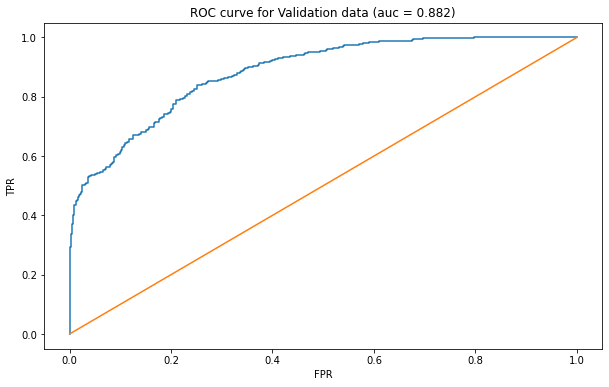

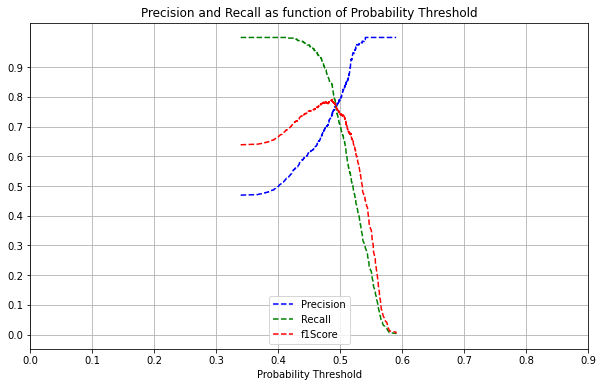

Validation data confusion matrix with 0.49344574066015107 threshold:
 predicted    0    1
actual             
0          428  109
1          109  366
Classification report Validation data:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       537
           1       0.77      0.77      0.77       475

    accuracy                           0.78      1012
   macro avg       0.78      0.78      0.78      1012
weighted avg       0.78      0.78      0.78      1012



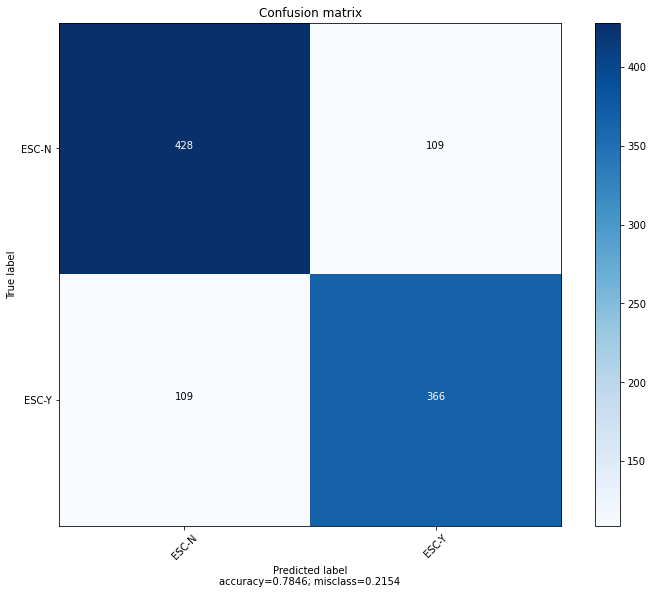

In [18]:
###Best: {'criterion': 1, 'max_depth': 5, 'max_features': 0, 'n_estimators': 3}
clf_rfc = RandomForestClassifier(max_depth=4, n_estimators=300, max_features = 'log2', 
                                    criterion='gini',random_state=0)
clf_rfc.fit(x_train_transform, y_train)
y_val_prob = clf_rfc.predict_proba(x_val_transform)[:,1]

print(clf_rfc.classes_)
threshold, scored_data, cnf_mat = validation_probability_threshold(y_val, y_val_prob, 'Validation')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

Shape of Test Matrix:(5058, 5005)
Shape of Test Target:(5058,)


/Users/mhsaleem/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


shape of y_test_proba (5058,)
Testing AUC is: 0.9104160166275804
shape of prt (5028, 5)
Probability threshold:0.4880380499062176


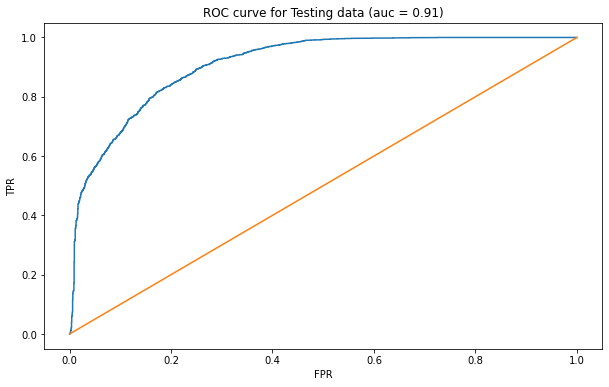

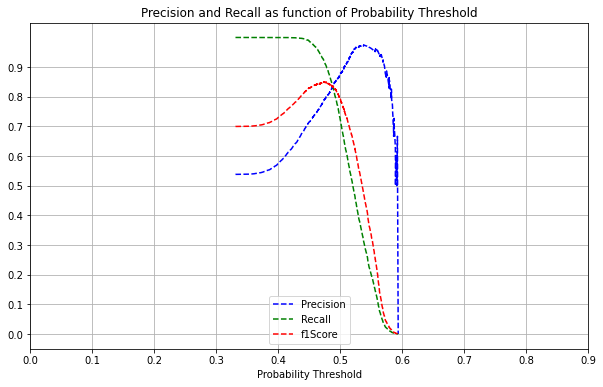

Testing data confusion matrix with 0.4880380499062176 threshold:
 predicted     0     1
actual               
0          1887   449
1           449  2273
Classification report Testing data:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2336
           1       0.84      0.84      0.84      2722

    accuracy                           0.82      5058
   macro avg       0.82      0.82      0.82      5058
weighted avg       0.82      0.82      0.82      5058



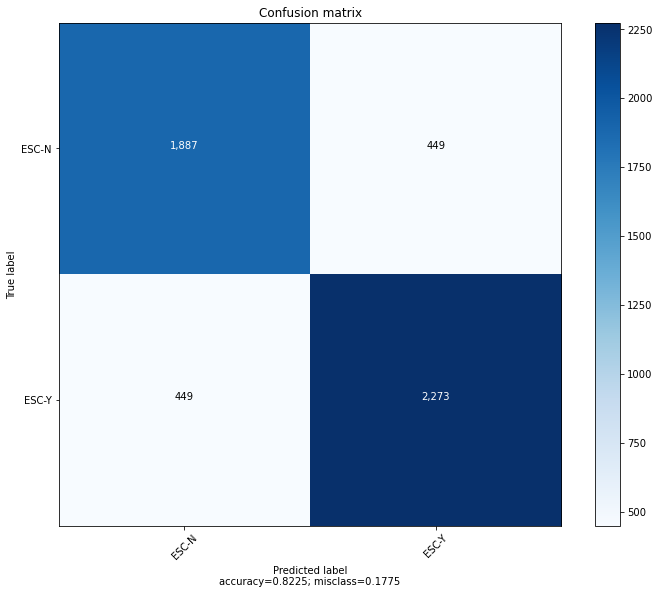

In [19]:

x_test_transform = tfidf_vectorizer.transform(df_test_tfidf.combined_clean)

x_test = np.concatenate((x_test_transform.todense(), df_test_tfidf[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)
y_test = df_test_tfidf['label']

# %%
print('Shape of Test Matrix:'+str(x_test.shape))
print('Shape of Test Target:'+str(y_test.shape))

# %%
y_test_proba = clf_rfc.predict_proba(x_test)[:,1]
print("shape of y_test_proba {}".format(y_test_proba.shape))

target_dict = {0: 'ESC-Y', 1: 'ESC-N'}

threshold, scored_data, cnf_mat = validation_probability_threshold(y_test, y_test_proba, 'Testing')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
current_wd

In [20]:
pickle.dump(clf_rfc, open(current_wd+'/output/random_forest_model.sav', 'wb'))

In [ ]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

In [ ]:
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01,
                                max_depth=3, 
                                random_state=0).fit(x_train_transform, y_train)
y_val_prob = clf_gbc.predict_proba(x_val_transform)[:,1]

print(clf_gbc.classes_)
threshold, scored_data, cnf_mat = validation_probability_threshold(y_val, y_val_prob, 'Validation')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:

x_test_transform = fitted_vectorizer.transform(df_test_tfidf.combined_clean)

x_test = np.concatenate((x_test_transform.todense(), df_test_tfidf[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)
y_test = df_test_tfidf['label']

# %%
print('Shape of Test Matrix:'+str(x_test.shape))
print('Shape of Test Target:'+str(y_test.shape))

# %%
y_test_proba = clf_gbc.predict_proba(x_test)[:,1]
print("shape of y_test_proba {}".format(y_test_proba.shape))

target_dict = {0: 'ESC-Y', 1: 'ESC-N'}

threshold, scored_data, cnf_mat = validation_probability_threshold(y_test, y_test_proba, 'Testing')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
clf_gnb = GaussianNB()
clf_gnb.fit(x_train_transform, y_train)

y_val_prob = clf_gnb.predict_proba(x_val_transform)[:,1]

print(clf_gnb.classes_)
threshold, scored_data, cnf_mat = validation_probability_threshold(y_val, y_val_prob, 'Validation')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:

x_test_transform = fitted_vectorizer.transform(df_test_tfidf.combined_clean)

x_test = np.concatenate((x_test_transform.todense(), df_test_tfidf[['wc_heading','wc_news','ratio_news_clean_orig','ratio_head_clean_orig','lstm_prob']].values), axis=1)
y_test = df_test_tfidf['label']

# %%
print('Shape of Test Matrix:'+str(x_test.shape))
print('Shape of Test Target:'+str(y_test.shape))

# %%
y_test_proba = clf_gnb.predict_proba(x_test)[:,1]
print("shape of y_test_proba {}".format(y_test_proba.shape))

target_dict = {0: 'ESC-Y', 1: 'ESC-N'}

threshold, scored_data, cnf_mat = validation_probability_threshold(y_test, y_test_proba, 'Testing')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope


In [ ]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500]),
    "max_depth": hp.choice("max_depth", [2, 4,5,6,7,8]),
    "max_features": hp.choice("max_features", ["sqrt","log2"]),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

# define objective function

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, x_train_transform, y_train,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)



In [ ]:
print("Best: {}".format(best))

In [ ]:
##Best: {'criterion': 1, 'max_depth': 5, 'max_features': 0, 'n_estimators': 3}

##### EMBEDDINGS

In [ ]:
# %%
####################################################################################
# key variables
####################################################################################
embedding_dim = 300
max_length = 900
save_label = 'lstm_model'
output_location = current_wd+'/output'

In [ ]:
#### --------
## SELF EMBEDDINGS
#### --------

df_vectors = pd.read_csv(current_wd+'/output/vectors_900s_300d.tsv', sep='\t',header=None)
df_words = pd.read_csv(current_wd+'/output/metadata_900s_300d.tsv', sep='\t',header=None)

word_vect = df_vectors.values
word_emb_dict = {}
for k,v in enumerate(df_words.values):
    word_emb_dict[v[0]] = word_vect[k]

#word_emb_dict['syria']

In [ ]:
word_emb_dict.keys()

In [ ]:
##--- GET GLOVE EMBEDDINGS
from tensorflow.python.client import device_lib
import json
import pickle

device_lib.list_local_devices()


# %%
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# %%
####################################################################################
# Get encoding from glove
####################################################################################
embeddings_index = {}
glove_embedding_path = current_wd+'/glove.6B.300d.txt'
with open(glove_embedding_path) as f:
    for line in f:   
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
embeddings_index['help']

In [ ]:
print(embeddings_index['syria'].shape)
print(word_emb_dict['syria'].shape)

In [ ]:
### create padded sequence function
def create_padded_seq (df, type_of_data, cols_to_use_list, output_location, save_label, embedding_dim, max_length):
    
    trunc_type = 'pre'
    padding_type = 'pre'
    oov_tok = "<oov>"

    a,t = None, None
    if len(cols_to_use_list) == 1:
        a = np.array(df[cols_to_use_list[0]].astype("str"))
        t = a
        #a = np.concatenate((a1,a2), axis=0)
    else:
        a1 = np.array(df[cols_to_use_list[0]].astype("str"))
        a2 = np.array(df[cols_to_use_list[1]].astype("str"))
        a = np.concatenate((a1,a2), axis=0)
        t = a1+' '+a2
    
    print("--- DONE CONCAT")
    # %%
    
    if type_of_data == 'TRAIN':
        tokenizer = Tokenizer(oov_token = oov_tok)
        tokenizer.fit_on_texts(a)
        
        # save tokenizer pickle
        #pickle_save_location = ""
        pickle_save_location = output_location+'/tokenizer_'+save_label+'.pkl'
        #print("pickle save location: %s" %pickle_save_location)
            
        print('tokenizer save location: '+str(pickle_save_location))
        with open(pickle_save_location, 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        # %%
        word_index = tokenizer.word_index
        vocab_size = len(word_index) + 1
        print('******* vocab size is:'+str(vocab_size))
        
        encoded_docs = tokenizer.texts_to_sequences(t)
        padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        
        # %%
        ####################################################################################
        # creating matrix for words and encoding
        ####################################################################################
        embeddings_matrix = np.zeros((vocab_size, embedding_dim))
        word_not_found = []

        for word, i in word_index.items():
            embedding_vector_learned = word_emb_dict.get(word)
            embedding_vector_glove = embeddings_index.get(word)

            if embedding_vector_learned is not None:
                embeddings_matrix[i] = embedding_vector_learned
            elif embedding_vector_glove is not None:
                embeddings_matrix[i] = embedding_vector_glove
            else:
                embeddings_matrix[i] = word_emb_dict.get('[UNK]')
                word_not_found.append(word)

        print('Shape of Embedding Matrix: '+str(embeddings_matrix.shape))
        print('Number of words not found in the embeddings: '+str(len(word_not_found)))

        return padded_sequence, embeddings_matrix, word_not_found, vocab_size
    else:
        pickle_saved_location = output_location+'/tokenizer_'+save_label+'.pkl'
            
        print('tokenizer saved location for test: '+str(pickle_saved_location))
        
        tokenizer = pickle.load(open(pickle_saved_location,'rb'))
        
        encoded_docs = tokenizer.texts_to_sequences(t)
        padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        
        return padded_sequence

##### Learn Embeddings

In [ ]:
def get_vocab(df, col_to_use):
    trunc_type = 'pre'
    padding_type = 'pre'
    oov_tok = "<oov>"

    a = np.array(df[col_to_use].astype("str"))
    tokenizer = Tokenizer(oov_token = oov_tok)
    tokenizer.fit_on_texts(a)

    # Get our training data word index
    word_index = tokenizer.word_index
    
    return word_index.keys()

In [ ]:
df_train.isna().sum()

In [ ]:
df_final_train = df_train.copy()#df_train[df_train.wc_news_clean > 10].copy()
df_final_train['combined_clean'] = df_final_train.clean_author + ' ' + df_final_train.clean_text
#df_final_test = df_test[df_test.wc_news_clean > 20].copy()

print(df_final_train.shape)
#print(df_final_test.shape)

In [ ]:
x_train, x_val, y_train_emb, y_val_emb = train_test_split(df_final_train.drop(columns=['label']), df_final_train['label'], 
                                                                            test_size=0.05, shuffle = True)

print('Shape of Training Matrix:'+str(x_train.shape))
print('Shape of Training Target:'+str(y_train_emb.shape))
print('Shape of Validation Matrix:'+str(x_val.shape))
print('Shape of Validation Target:'+str(y_val_emb.shape))

#x_train_emb = x_train['combined_clean']
#x_val_emb = x_val['combined_clean']

In [ ]:
x_train.combined_clean.head(2).to_dict()

In [ ]:
vocab_dict = get_vocab(x_train, 'combined_clean')
print("total vocab: %d"%len(list(vocab_dict)))

In [ ]:
vocab_dict

In [ ]:
### LEARN EMBEDDINGS
# Vocabulary size and number of words in a sequence.
vocab_size = len(vocab_dict) + 10
sequence_length = 900

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    vocabulary=list(vocab_dict))


In [ ]:
vectorize_layer.get_vocabulary()

In [ ]:
embedding_dim = 300

model_embedding = tf.keras.Sequential()
model_embedding.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_embedding.add(vectorize_layer)
model_embedding.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding"))
model_embedding.add(tf.keras.layers.GlobalAveragePooling1D())
model_embedding.add(tf.keras.layers.Dense(embedding_dim, activation='relu'))
model_embedding.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_embedding.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model_embedding.summary()

In [ ]:
model_embedding.fit(x_train['combined_clean'].to_list(),
y_train_emb.to_list(),
validation_data=(x_val['combined_clean'].to_list(),y_val_emb.to_list()), 
epochs=7)

In [ ]:
weights = model_embedding.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
import io
out_v = io.open(current_wd+'/output/vectors_900s_300d.tsv', 'w', encoding='utf-8')
out_m = io.open(current_wd+'/output/metadata_900s_300d.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

##### TRAIN

In [ ]:
df_final_train = df_train[df_train.wc_news_clean > 10].copy()
df_final_test = df_test[df_test.wc_news_clean > 10].copy()

print(df_final_train.shape)
print(df_final_test.shape)

In [ ]:
#df_final_train.dtypes

In [ ]:
df_final_train['combined_clean'] =  df_final_train.clean_author + ' ' + df_final_train.clean_text
df_final_test['combined_clean'] =  df_final_test.clean_author + ' ' + df_final_test.clean_text

In [ ]:
#v = df_final_train['combined_clean'].str.split().tolist()
#c = Counter(chain.from_iterable(v))

In [ ]:
####################################################################################
# train validation split
####################################################################################
x_train, x_val, y_train, y_val = train_test_split(df_final_train, 
                                                    df_final_train['label'], 
                                                    test_size=0.1, shuffle = True)

print('Shape of Training Matrix:'+str(x_train.shape))
print('Shape of Training Target:'+str(y_train.shape))
print('Shape of Validation Matrix:'+str(x_val.shape))
print('Shape of Validation Target:'+str(y_val.shape))

In [ ]:
vocab_dict_train = get_vocab(x_train, 'combined_clean')
vocab_dict_val = get_vocab(x_val, 'combined_clean')
vocab_dict_test = get_vocab(df_final_test, 'combined_clean')

print(len(vocab_dict_train))
print(len(vocab_dict_val))
print(len(vocab_dict_test))

In [ ]:
x_padded_sequence_train, embeddings_matrix, word_not_found, vocab_size = create_padded_seq(x_train, 'TRAIN', 
                                                                       ['combined_clean'],
                                                                      output_location, save_label, embedding_dim, max_length)
print("GOT PADDED DATA")

In [ ]:
# saving the embedding matrix in the 'npy' format
np.save(current_wd+'/output/embedding_matrix.npy', embeddings_matrix)
print("Done writing matrix")

In [ ]:
embeddings_matrix

In [ ]:
embeddings_matrix_loaded = np.load(current_wd+'/output/embedding_matrix.npy')

In [ ]:
embeddings_matrix_loaded

In [ ]:
embeddings_matrix

In [ ]:
 #embeddings_index, word_emb_dict
missing_words=[]
for single_word in list(vocab_dict_test):
    if single_word not in list(vocab_dict_train):
        missing_words.append(single_word)

print(len(missing_words))

In [ ]:
missing_words

train vs word_emb = 1390
train vs glove = 23900

val vs word_emb = 148
val vs glove = 5657

test vs word_emb = 20193
test vs glove = 19957

In [ ]:
#word_emb_dict.keys()
embeddings_matrix

In [ ]:
x_padded_sequence_val = create_padded_seq(x_val, 'TEST', 
                                           ['combined_clean'],
                                          output_location, save_label, embedding_dim, max_length)

In [ ]:
vocab_size = len(vocab_dict_train) + 10
#max_length = 1500
vectorize_layer_lstm = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
    vocabulary=list(word_emb_dict.keys()))

In [ ]:
vectorize_layer_lstm.get_vocabulary()

In [ ]:
print(vocab_size, embedding_dim)
embeddings_matrix = np.zeros((vocab_size, embedding_dim))

for i,word in enumerate(vocab_dict_train):
    #print(word)
    if word in word_emb_dict:
        embeddings_matrix[i] = word_emb_dict.get(word)
    else:
        embeddings_matrix[i] = word_emb_dict.get('[UNK]')

In [ ]:
embeddings_matrix[0]

In [ ]:


####################################################################################
# Model Training
####################################################################################
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy')
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc')
]

model_lstm = tf.keras.Sequential()
#model_lstm.add(tf.keras.Input(shape=(1,), dtype=tf.string))
#model_lstm.add(vectorize_layer_lstm)
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                         embedding_dim, 
                                         input_length=max_length,
                                         weights=[embeddings_matrix_loaded],
                                         #mask_zero=True,
                                         trainable=False))
model_lstm.add(tf.keras.layers.LSTM(100, return_sequences=False, activation='tanh', dropout=0.2))
#model_lstm.add(tf.keras.layers.LSTM(150, return_sequences=True))
model_lstm.add(tf.keras.layers.Dropout(0.4))
model_lstm.add(tf.keras.layers.Dense(50, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.4))
model_lstm.add(tf.keras.layers.Dense(10, activation='relu'))
#model_lstm.add(tf.keras.layers.Flatten())
model_lstm.add(tf.keras.layers.Dropout(0.4))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=1e-05, epsilon=1e-08,clipnorm=1.0), 
                   metrics=METRICS)
model_lstm.summary()

In [ ]:
#x_padded_sequence_train.shape

In [ ]:
# %%
###SEED
from numpy.random import seed
#from tensorflow import set_random_seed
from random import randint

seed_to_use = 40 #randint(1, 60)
print("seed used in numpy %s" %seed_to_use)
seed(seed_to_use)
print("seed use0 in tf %s" %seed_to_use)
#set_random_seed(seed_to_use)

#seeds working 35

num_epochs = 5
batch_size = 60
sample_weight_train = np.ones(shape=(len(y_train),))
sample_weight_train[y_train == 1] = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)
history = model_lstm.fit(x_padded_sequence_train, y_train, 
                         epochs=num_epochs,
                         callbacks = [early_stopping],
                         batch_size=batch_size,
                         validation_data = (x_padded_sequence_val, y_val),
                         #validation_split= 0.1, #(x_padded_sequence_val, y_val), 
                         #sample_weight = sample_weight_train,
                         verbose=1)

print("Training Complete")

In [ ]:
...
# list all data in history
print(history.history.keys())

In [ ]:
def plot_training_charts(hist, metric_name):
    plt.plot(hist.history[metric_name])
    plt.plot(hist.history['val_'+metric_name])
    plt.title('model'+ ' ' +metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show()

In [ ]:
# summarize history for accuracy
plot_training_charts(history, 'accuracy')

plot_training_charts(history, 'loss')
 

In [ ]:
#df_final_test_use = df_final_test[df_final_test.hc_mc_thread_sequence <3]

x_padded_sequence_test = create_padded_seq(df_final_test, 'TEST', 
                                           ['combined_clean'],
                                          output_location, save_label, embedding_dim, max_length)

x_test = x_padded_sequence_test #df_final_test['combined_clean']
y_test = df_final_test['label']


# %%
print('Shape of Test Matrix:'+str(x_test.shape))
print('Shape of Test Target:'+str(y_test.shape))


# %%
y_test_proba = model_lstm.predict(x_test)


target_dict = {0: 'ESC-Y', 1: 'ESC-N'}

threshold, scored_data, cnf_mat = validation_probability_threshold(y_test, y_test_proba, 'Testing')
plot_confusion_matrix(cnf_mat, [target_dict[1], target_dict[0]], title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
print(output_location+'/model_lstm2_'+save_label+'.h5')
tf.keras.models.save_model(model_lstm,output_location+'/model_lstm_'+save_label+'.h5')
print("Model Saved")



In [ ]:
new_model = tf.keras.models.load_model(output_location+'/model_lstm_'+save_label+'.h5')

In [ ]:
df_to_use = df_final_train
padded_seq = create_padded_seq(df_to_use, 'TEST', 
                                ['combined_clean'],
                                output_location, save_label, embedding_dim, max_length)

print(df_final_train.shape)
print(padded_seq.shape)

In [ ]:
y_lstm_prob_model = model_lstm.predict(padded_seq)
print(y_lstm_prob_model.shape)
df_to_use['lstm_prob'] = y_lstm_prob_model

df_to_use.to_csv(current_wd+'/output/df_train_clean_lstm.csv')
print("DONE WRITING {}".format(df_to_use.shape))

#### BERT

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=512):
    """Returns Model mapping string features to BERT inputs.
    Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.
    Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
    """

    input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string,
                      name=ft) for ft in sentence_features]

    # Tokenize the text to word pieces.

    bert_preprocess = hub.load(tfhub_handle_preprocess)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize,
                               name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.

    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.

    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(truncated_segments)
    return tf.keras.Model(input_segments, model_inputs)

In [ ]:
text_test = ['america']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
def text_to_emb(input_text):
  input_text_lst = [input_text]
  inputs = bert_preprocess_model(input_text_lst)
  outputs = bert_model(inputs)
  return np.array((outputs['pooled_output']))

(text_to_emb('syria')).shape

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = make_bert_preprocess_model(['customer_text_clean'])  # hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.6)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier' )(net)
  return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 1
batch_size = 600
steps_per_epoch = x_train.shape[0] / batch_size #tf.data.experimental.cardinality(x_train['combined_clean']).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
#text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
#bert_raw_result = classifier_model(tf.constant(text_test))
#print(tf.sigmoid(bert_raw_result))

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#epochs = 2
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x_train['combined_clean'],y_train,
                               validation_data=(x_val['combined_clean'], y_val),
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate(x = df_final_test['combined_clean'], y=df_final_test['label'])

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
sample_sent = ['america']
test_preprocess_model_custom = make_bert_preprocess_model(['my_input1'])
text_preprocessed = test_preprocess_model_custom(np.array(sample_sent))

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
#print(f'Input Mask : {a["input_mask"][0, :12]}')
#print(f'Type Ids   : {a["input_type_ids"][0, :12]}')